<a href="https://colab.research.google.com/github/Jugranada/Aprendizaje_Maquina/blob/main/parcial_1/Parcial_1_TAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Ejercicio 1**

Sea el modelo de regresión:

$[
t_n = \phi(x_n) w^\top + \eta_n,
]$

con

$[
\{ t_n \in \mathbb{R}, \; x_n \in \mathbb{R}^P \}_{n=1}^N, \quad
w \in \mathbb{R}^Q, \quad
\phi : \mathbb{R}^P \rightarrow \mathbb{R}^Q, \quad Q \geq P,
]$
y

$[
\eta_n \sim \mathcal{N}(\eta_n | 0, \sigma_\eta^2).
]$

---

##  Objetivo

Presente el **problema de optimización** y la **solución analítica** para los siguientes modelos de regresión:

1. **Mínimos Cuadrados Ordinarios (OLS)**  
2. **Mínimos Cuadrados Regularizados (Ridge)**  
3. **Máxima Verosimilitud (ML)**  
4. **Máximo a Posteriori (MAP)**  
5. **Regresión Bayesiana con modelo lineal Gaussiano**  
6. **Regresión Rígida Kernel (Kernel Ridge Regression)**  
7. **Regresión mediante Procesos Gaussianos (Gaussian Processes)**  

---

##  Instrucciones

- Asuma datos **i.i.d.** (independientes e idénticamente distribuidos).  
- Para cada modelo, **presente el problema de optimización** y su **solución cerrada o analítica**.  
- **Explique** las hipótesis, supuestos y pasos de derivación.  
- **Discuta** las diferencias y similitudes entre los modelos estudiados,
---


##  **Generacion de Datos**

el modelo de señal se define como:

$[
t^*(x) = A \sin(2\pi F_0 x)
]$

donde:
- $( A )$ es la amplitud de la señal,
- $( F_0 )$ es la frecuencia fundamental,
- $( x )$ es el vector de muestras en el tiempo.

La señal observada se obtiene como:

$[
t(x) = t^*(x) + \eta(x)
]$

donde el término de ruido $( \eta(x) )$ es un proceso aleatorio gaussiano con varianza determinada por el SNR deseado:

$[
\sigma_\eta^2 = \frac{P_x}{10^{\frac{\text{SNR}_{dB}}{10}}}
]$

con $( P_x = \mathbb{E}[t^*(x)^2] )$ siendo la potencia promedio de la señal limpia.

---

1. **Cálculo de la varianza del ruido (`var_snr`)**  
   Se implementa una función auxiliar que recibe la señal limpia $( x )$ y el valor de SNR en decibelios, y devuelve la varianza del ruido necesaria para lograr dicha relación:
   $[
   \text{var_snr}(x, \text{SNR}_{dB}) = \frac{\mathbb{E}[x^2]}{10^{\frac{\text{SNR}_{dB}}{10}}}
   ]$
   Esto garantiza que el ruido añadido mantenga la proporción de energía especificada.

2. **Parámetros de la señal**  
   Se fija una frecuencia fundamental $( F_0 = 60\,\text{Hz} )$, una amplitud $( A = 10 )$, y una frecuencia de muestreo $( F_s = 100 F_0 )$ (satisfaciendo ampliamente el criterio de Nyquist).  
   El período de la señal es $( T_0 = \frac{1}{F_0} )$, y el vector de tiempo se genera como:
   $[
   X = \{0, \tfrac{1}{F_s}, \tfrac{2}{F_s}, \dots, T_0 - \tfrac{1}{F_s}\}
   ]$

3. **Generación de la señal limpia**  
   Se obtiene la señal base senoidal:
   $[
   t^*(x) = A \sin(2\pi F_0 x)
   ]$

4. **Adición de ruido gaussiano**  
   A la señal limpia se le suma un término de ruido blanco gaussiano de varianza calculada mediante la función `var_snr()`:
   $[
   t(x) = t^*(x) + \sqrt{\sigma_\eta^2}\, \mathcal{N}(0,1)
   ]$
   donde $( \mathcal{N}(0,1) )$ representa una variable aleatoria normal estándar.

5. **Ajuste de dimensiones**  
   Los vectores $( X )$ y $( t )$ se remodelan a formato columna (`(n_muestras, 1)`), lo cual facilita su uso en los modelos posteriores.

6. **Visualización de los datos**  
   Se grafica la señal limpia en color rojo y la señal ruidosa mediante puntos azules.  
   Esto permite observar visualmente el efecto del ruido y verificar la correcta simulación de los datos.
---


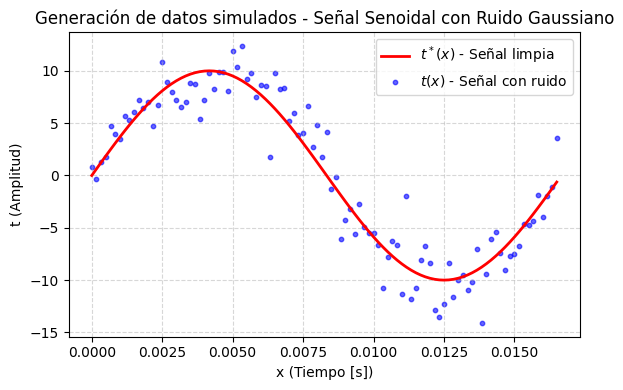

In [ ]:
# ============================================================
# PREPARACIÓN DE DATOS COMUNES
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Función: cálculo de la varianza del ruido a partir del SNR en dB
# Entradas:
#   x: vector de datos (señal limpia)
#   snrdB: relación señal-ruido en decibelios (SNR[dB])
# Salida:
#   varianza del ruido necesaria para alcanzar el SNR especificado
# ------------------------------------------------------------
def var_snr(x, snrdB):
    Px = np.mean(x**2)                   # Potencia media de la señal
    Pn = Px / (10**(snrdB/10))           # Potencia del ruido a partir del SNR
    return Pn                            # Devuelve la varianza del ruido

# ------------------------------------------------------------
# Parámetros del modelo de señal
# ------------------------------------------------------------
Fo = 60                 # Frecuencia fundamental [Hz]
A = 10                  # Amplitud de la señal
To = 1/Fo               # Período fundamental [s]
Fs = 100 * Fo           # Frecuencia de muestreo (100x la fundamental)
snrdB = 10              # Relación señal-ruido en decibelios (SNR[dB])

# ------------------------------------------------------------
# Vector de entrada y generación de señal
# ------------------------------------------------------------
X = np.arange(0, To, 1/Fs)               # Vector de tiempo dentro de un período
tt = A * np.sin(2*np.pi*Fo*X)            # Señal limpia (objetivo teórico)

# ------------------------------------------------------------
# Generación de señal ruidosa (ruido blanco Gaussiano)
# ------------------------------------------------------------
var_noise = var_snr(tt, snrdB)           # Varianza del ruido según el SNR
t = tt + np.sqrt(var_noise) * np.random.randn(len(X))  # Señal contaminada

# ------------------------------------------------------------
# Ajuste de dimensiones (n muestras x 1 característica)
# ------------------------------------------------------------
X = X.reshape(-1, 1)                     # Vector de entrada como columna
t = t.reshape(-1, 1)                     # Vector de salida como columna

# ------------------------------------------------------------
# Visualización de los datos simulados
# ------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(X, tt, c='r', linewidth=2, label='$t^*(x)$ - Señal limpia')
plt.scatter(X, t, c='b', s=10, alpha=0.6, label='$t(x)$ - Señal con ruido')
plt.title('Generación de datos simulados - Señal Senoidal con Ruido Gaussiano')
plt.xlabel('x (Tiempo [s])')
plt.ylabel('t (Amplitud)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Nota:
# Los vectores X y t generados aquí serán utilizados por todos
# los modelos (OLS, Ridge, ML, MAP, Bayesiano, Kernel Ridge, GP)
# ------------------------------------------------------------


###  **Mínimos Cuadrados Ordinarios (OLS)**

El modelo lineal base se define como:

$[
t_n = \boldsymbol{\phi}(\mathbf{x}_n)^\top \mathbf{w} + \eta_n,
]$

donde:
- $( t_n \in \mathbb{R} )$ es la salida observada,
- $( \mathbf{x}_n \in \mathbb{R}^P )$ es la entrada,
- $( \boldsymbol{\phi}(\mathbf{x}_n) \in \mathbb{R}^Q )$ es la representación del vector de características (por ejemplo, polinómica),
- $( \eta_n \sim \mathcal{N}(0, \sigma_\eta^2) )$ es el ruido Gaussiano aditivo,
- y $( \mathbf{w} \in \mathbb{R}^Q )$ son los pesos del modelo a estimar.

---

####  Formulación matricial

Apilando las observaciones en forma matricial:

$[
\mathbf{t} = \Phi \mathbf{w} + \boldsymbol{\eta},
]$

donde:
- $(\Phi = [\boldsymbol{\phi}(\mathbf{x}_1)^\top, \dots, \boldsymbol{\phi}(\mathbf{x}_N)^\top]^\top \in \mathbb{R}^{N \times Q})$,
- $(\mathbf{t} = [t_1, \dots, t_N]^\top \in \mathbb{R}^{N})$.

---

####  Implementación

En el código, la matriz de diseño $(\Phi)$ se genera mediante `PolynomialFeatures`, que expande los datos $(X)$ hasta grado $(Q)$

El modelo se entrena con `LinearRegression(fit_intercept=False)`, que internamente implementa la solución anterior

$[
\texttt{LinearRegression} \; \Rightarrow \; \mathbf{w}_{OLS} = (\Phi^\top \Phi)^{-1} \Phi^\top \mathbf{t}.
]$

---

#### 📈 Predicción y visualización

Las predicciones para las muestras de prueba se calculan como:

$[
\hat{\mathbf{t}} = \Phi_{\text{test}} \, \mathbf{w}_{OLS}.
]$

En la gráfica se comparan:
- $(t^*(x))$: la señal real sin ruido,
- $(t(x))$: los datos observados con ruido,
- $(\hat{t}(x))$: la predicción del modelo OLS.

---


Partición 1: 80 train, 20 test


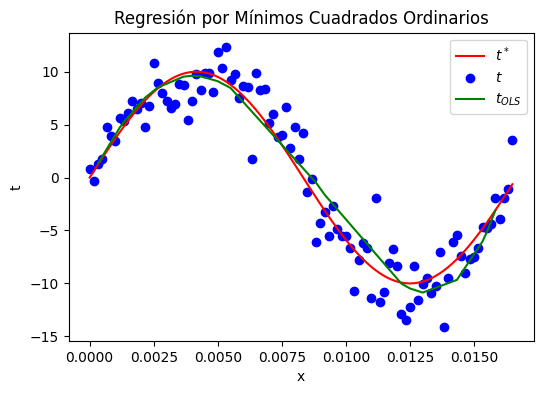

In [ ]:
# ==============================================================
#  MÍNIMOS CUADRADOS ORDINARIOS (OLS)
# ==============================================================
# Modelo: t = Φw^T + η ,   con w_ML = (Φ^T Φ)^(-1) Φ^T t
# Implementación mediante sklearn.linear_model.LinearRegression
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit

# --------------------------------------------------------------
# 1. Generación de la representación polinomial Φ(x)
# --------------------------------------------------------------
Q = 4  # grado del polinomio -> define dimensión Q de Φ(x)
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)  # Φ ∈ R^{N x (Q+1)}

# --------------------------------------------------------------
# 2. División del conjunto de datos (train / test)
# --------------------------------------------------------------
# Usamos ShuffleSplit para obtener índices aleatorios reproducibles
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)

for i, (train_i, test_i) in enumerate(rs.split(X)):
    print(f"Partición {i+1}: {len(train_i)} train, {len(test_i)} test")

train_i = np.sort(train_i)
test_i = np.sort(test_i)

# --------------------------------------------------------------
# 3. Definición y entrenamiento del modelo lineal
# --------------------------------------------------------------
# LinearRegression implementa internamente la solución cerrada:
# w_OLS = (Φ^T Φ)^(-1) Φ^T t
reg_ols = LinearRegression(fit_intercept=False)
# (fit_intercept=False porque el término independiente ya está incluido en Φ)

reg_ols.fit(Phi[train_i], t[train_i])  # estimación de w_OLS

# --------------------------------------------------------------
# 4. Predicción sobre el conjunto de test
# --------------------------------------------------------------
t_ols = reg_ols.predict(Phi[test_i])  # t̂ = Φ w_OLS^T

# --------------------------------------------------------------
# 5. Visualización de resultados
# --------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(X, tt, c='r', label='$t^*$')            # señal real (sin ruido)
plt.scatter(X, t, c='b', label='$t$')            # muestras con ruido
plt.plot(X[test_i], t_ols, c='g', label='$t_{OLS}$')  # estimación modelo OLS
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Regresión por Mínimos Cuadrados Ordinarios')
plt.show()

# --------------------------------------------------------------
# 6. Comentario teórico
# --------------------------------------------------------------
# En este bloque, sklearn resuelve el sistema normal:
#     (Φ^T Φ) w = Φ^T t
# Su solución analítica (cerrada) es:
#     w_OLS = (Φ^T Φ)^(-1) Φ^T t
# La predicción resultante:
#     t̂ = Φ w_OLS^T
# corresponde al estimador de mínima varianza insesgado bajo
# la hipótesis de ruido blanco Gaussiano η ~ N(0, σ_η²)


###  **Mínimos Cuadrados Regularizados (Ridge Regression)**

En este modelo se busca mitigar el problema de **sobreajuste** y la **inestabilidad numérica** que puede aparecer en la regresión por mínimos cuadrados ordinarios (OLS), especialmente cuando las variables predictoras están altamente correlacionadas o la matriz de diseño $(\Phi^\top \Phi)$ es mal condicionada.  

La función objetivo en Ridge incluye un término de **penalización L2** sobre los coeficientes $(w)$, controlado por un parámetro de regularización $(\lambda)$:

$[
E(\mathbf{w}) = \frac{1}{2N}\|\mathbf{t} - \Phi \mathbf{w}\|^2 + \frac{\lambda}{2} \|\mathbf{w}\|^2
]$

donde:
- $(\mathbf{t})$ es el vector de valores observados.
- $(\Phi)$ es la matriz de diseño (las bases polinómicas de los datos de entrada).
- $(\mathbf{w})$ son los coeficientes del modelo.
- $(\lambda)$ controla el grado de regularización:  
  - Si $(\lambda \to 0)$, el modelo se aproxima a OLS.  
  - Si $(\lambda \to \infty)$, los pesos tienden a cero, y el modelo se vuelve muy suave.

La **solución cerrada** del modelo Ridge es:

$[
\mathbf{w}_{ridge} = (\Phi^\top \Phi + \lambda I)^{-1} \Phi^\top \mathbf{t}
]$

---

####  Implementación en código

En el bloque de código se siguen los siguientes pasos:

1. **Construcción de la matriz de diseño**
   Se utiliza `PolynomialFeatures` para crear las columnas de la matriz $(\Phi)$ correspondientes a las potencias de $(x)$, es decir:
   $[
   \Phi = [1, x, x^2, x^3, \dots, x^M]
   ]$
   con $(M)$ el grado del polinomio elegido.

3. **Ajuste del modelo Ridge**
   Se utiliza el método `Ridge()` de `scikit-learn`, que internamente implementa la solución analítica anterior.  
   El parámetro `alpha` corresponde directamente a $(\lambda)$:
   ```python
   reg_ridge = Ridge(alpha=lambdaR, fit_intercept=False)
   reg_ridge.fit(Phi, t)


División 1 realizada.


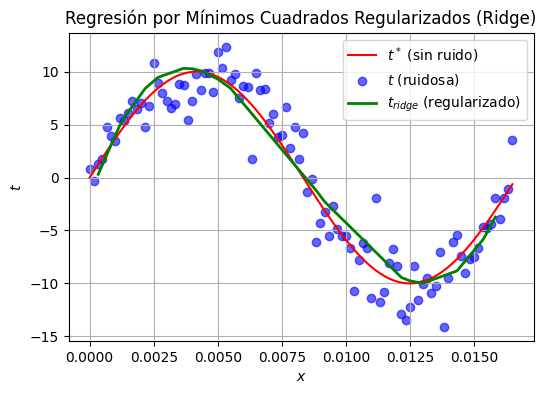

In [ ]:
# ============================================================
#  MÍNIMOS CUADRADOS REGULARIZADOS (RIDGE)
# ============================================================

# En este modelo, se añade un término de regularización L2 al error cuadrático.
# La función de costo es:
#     E(w) = (1/2) ||t - Φw||^2 + (λ/2) ||w||^2
# Su solución cerrada es:
#     w_ridge = (ΦᵀΦ + λI)⁻¹ Φᵀt

from sklearn.linear_model import Ridge             # Modelo Ridge (regularización L2)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1) Representación polinómica de las entradas
# ------------------------------------------------------------

Q = 4  # Grado del polinomio (mismo que en OLS para comparación)
phiQ = PolynomialFeatures(degree=Q)  # Crea las funciones base polinómicas ϕ(x)
Phi = phiQ.fit_transform(X)           # Aplica la transformación → matriz Φ

# ------------------------------------------------------------
# 2) División de los datos en entrenamiento y prueba
# ------------------------------------------------------------

rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)  # partición aleatoria (20% test)
for i, (train_i, test_i) in enumerate(rs.split(X)):            # devuelve índices train/test
    print(f"División {i+1} realizada.")

# Ordenar los índices (para graficar en orden)
train_i = np.sort(train_i)
test_i = np.sort(test_i)

# ------------------------------------------------------------
# 3) Definición del modelo Ridge (mínimos cuadrados regularizados)
# ------------------------------------------------------------

lambdaR = 1e-14  # λ = parámetro de regularización
# En la teoría: (ΦᵀΦ + λI)⁻¹Φᵀt  ⇒ penaliza grandes valores de w para evitar sobreajuste
reg_ridge = Ridge(alpha=lambdaR, fit_intercept=False)

# ------------------------------------------------------------
# 4) Entrenamiento del modelo
# ------------------------------------------------------------

# Ajustar el modelo con los datos de entrenamiento
reg_ridge.fit(Phi[train_i], t[train_i])

# ------------------------------------------------------------
# 5) Predicción sobre los datos de prueba
# ------------------------------------------------------------

t_ridge = reg_ridge.predict(Phi[test_i])  # salida predicha t̂ = Φ_test w_ridge

# ------------------------------------------------------------
# 6) Visualización de resultados
# ------------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(X, tt, c='r', label='$t^*$ (sin ruido)')         # señal real
plt.scatter(X, t, c='b', label='$t$ (ruidosa)', alpha=0.6) # datos observados
plt.plot(X[test_i], t_ridge, c='g', lw=2, label='$t_{ridge}$ (regularizado)')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Regresión por Mínimos Cuadrados Regularizados (Ridge)')
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# Comentario final:
# ------------------------------------------------------------
# A diferencia del OLS, este modelo introduce λ||w||² en la función de costo,
# lo que "encoge" los coeficientes y reduce la varianza del modelo.
# La solución teórica corresponde a:
#     w_ridge = (ΦᵀΦ + λI)⁻¹ Φᵀt
# donde λ controla el compromiso entre ajuste y suavidad.


### **Máxima Verosimilitud (ML)**

---

###  Fundamento teórico

El método de **Máxima Verosimilitud (Maximum Likelihood, ML)** busca estimar los parámetros de un modelo probabilístico que **maximicen la probabilidad de observar los datos medidos**.  
En el caso de una regresión lineal con ruido gaussiano, se asume que:

$[
t_n = \phi(x_n)^\top w + \eta_n, \quad \eta_n \sim \mathcal{N}(0, \sigma^2)
]$

donde:
- $( t_n )$ son las observaciones (valores medidos),
- $( \phi(x_n) )$ son las funciones base o entradas polinómicas,
- $( w )$ son los coeficientes del modelo,
- $( \eta_n )$ es el ruido gaussiano con varianza \( \sigma^2 \).

---

###  Función de verosimilitud

Dado el conjunto de observaciones $( \{t_n\} )$, la **verosimilitud** del modelo está dada por:

$[
p(t | X, w, \sigma^2) = \prod_{n=1}^{N} \mathcal{N}(t_n | \phi(x_n)^\top w, \sigma^2)
]$

El logaritmo de la verosimilitud (log-verosimilitud) es:

$[
\ln p(t|X, w, \sigma^2) = -\frac{N}{2}\ln(2\pi\sigma^2)
 - \frac{1}{2\sigma^2} \sum_{n=1}^{N}(t_n - \phi(x_n)^\top w)^2
]$

---

###  Estimadores por ML

Para obtener las estimaciones de los parámetros, se maximizan las ecuaciones anteriores respecto a $( w )$ y $( \sigma^2 )$.

- **Estimador de los pesos $( w_{ML} )$:**
  $[
  w_{ML} = (\Phi^\top \Phi)^{-1} \Phi^\top t
  ]$
  que corresponde exactamente al estimador de **Mínimos Cuadrados Ordinarios (OLS)**.

- **Estimador de la varianza $( \sigma^2_{ML} )$:**
  $[
  \hat{\sigma}^2_{ML} = \frac{1}{N}\sum_{n=1}^{N}(t_n - \phi(x_n)^\top w_{ML})^2
  ]$

---


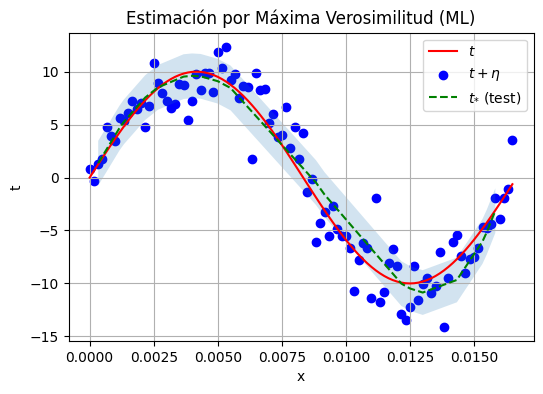

Varianza estimada (σ²_ML): 4.461896467574418


In [ ]:
# ------------------------------------------------------------
# predictiva ML
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# asumimos que el modelo OLS entrenado se llama reg_ols (análogo a reg_mc)
# y que Phi, train_i, test_i, X, t, tt ya existen en el entorno

# 1) calcular varianza ML a partir de los residuos en TRAIN
# convertir a vectores 1D para evitar problemas de shape
res_train = t[train_i].ravel() - reg_ols.predict(Phi[train_i]).ravel()
var_ml = (np.linalg.norm(res_train)**2) / len(res_train)

# 2) predicción en TEST
t_mc = reg_ols.predict(Phi[test_i]).ravel()   # vector 1D de predicciones en test

# 3) ordenar los puntos de test por X para que la línea no haga zig-zag
order = np.argsort(X[test_i].ravel())
X_test_sorted = X[test_i].ravel()[order]
t_mc_sorted = t_mc[order]


# 4) gráfica
plt.figure(figsize=(6,4))
plt.plot(X, tt, c='r', label='$t$')                      # señal limpia
plt.scatter(X, t, c='b', label='$t+\\eta$')              # datos ruidosos

# también dibujamos la predicción solamente en test (idéntico al ejemplo)
plt.plot(X_test_sorted, t_mc_sorted, c='g', linestyle='--', label='$t_{*}$ (test)')

# banda de incertidumbre alrededor de la predicción en TEST (misma sintaxis que el ejemplo)
plt.fill_between(
    X_test_sorted,
    t_mc_sorted - np.sqrt(var_ml) * np.ones(len(t_mc_sorted)),
    t_mc_sorted + np.sqrt(var_ml) * np.ones(len(t_mc_sorted)),
    alpha=0.2
)

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Estimación por Máxima Verosimilitud (ML)')
plt.grid(True)
plt.show()

print("Varianza estimada (σ²_ML):", var_ml)


#### **MÁXIMO A POSTERIORI (MAP)**

En este bloque implementamos la **estimación por Máximo a Posteriori (MAP)**, un método
de inferencia bayesiana que permite encontrar los pesos más probables del modelo
dadas las observaciones ruidosas.

---

###  Fundamento teórico

En un modelo de regresión lineal con ruido gaussiano, la relación entre las variables se describe como:

$[
t = \Phi w + \eta
]$
donde:
- $( t )$ son las observaciones (valores medidos),
- $( \Phi )$ es la matriz de diseño (bases polinómicas o funciones de entrada),
- $( w )$ es el vector de pesos del modelo,
- $( \eta \sim \mathcal{N}(0, \sigma_\eta^2 I) )$ es el ruido gaussiano.

A diferencia de los mínimos cuadrados ordinarios (OLS), el modelo **MAP** introduce
una **distribución a priori sobre los pesos** del modelo, también gaussiana:

$[
p(w) = \mathcal{N}(0, \sigma_w^2 I)
]$

La estimación MAP se obtiene aplicando el **Teorema de Bayes**:

$[
p(w|t) \propto p(t|w) \, p(w)
]$

Maximizar esta probabilidad equivale a minimizar la siguiente función de costo:

$[
E(w) = \frac{1}{2\sigma_\eta^2} \| t - \Phi w \|^2 + \frac{1}{2\sigma_w^2} \| w \|^2
]$

---

### Solución analítica

Derivando respecto a $( w )$ y anulando el gradiente:

$[
\frac{\partial E(w)}{\partial w} = 0
\quad \Rightarrow \quad
w_{MAP} = (\Phi^T \Phi + \lambda I)^{-1} \Phi^T t
]$

donde el parámetro de regularización **λ** surge de la relación entre las varianzas:

$[
\lambda = \frac{\sigma_\eta^2}{\sigma_w^2}
]$

Esta expresión es **idéntica a la de Ridge Regression**, pero aquí **λ tiene interpretación probabilística**.

---

### Varianza predictiva

La incertidumbre sobre una predicción $( t_* )$ para una nueva entrada $( \Phi_* )$ se estima como:

$[
\mathrm{Var}[t_*] = \sigma_\eta^2 + \Phi_* (\Phi^T \Phi + \lambda I)^{-1} \Phi_*^T
]$

En la práctica, se puede aproximar esta varianza mediante el error cuadrático medio en el conjunto de entrenamiento:

$[
\sigma_{MAP}^2 = \frac{1}{N_{train}} \| t_{train} - \Phi_{train} w_{MAP} \|^2
]$

Esta varianza define la **banda de incertidumbre ±σ** que se muestra en la gráfica.

---

λ (MAP) = 1.00e-14


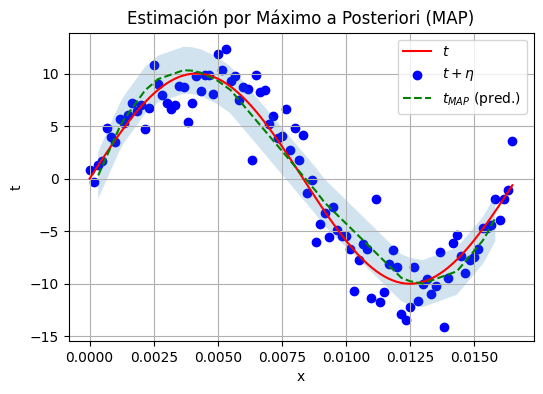

Varianza estimada (σ²_MAP): 4.994651727343692


In [ ]:
# ============================================================
#  MÁXIMO A POSTERIORI (MAP)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Definición de hiperparámetros del modelo
# ------------------------------------------------------------
sigma_eta = 0.1        # desviación estándar del ruido observado
sigma_w   = 1.0        # desviación estándar del prior sobre los pesos
lambda_map = 1e-14     # λ ≈ σ_η² / σ_w²  (valor pequeño para no sobre-regularizar)

print(f"λ (MAP) = {lambda_map:.2e}")

# ------------------------------------------------------------
# 2) Cálculo de los pesos w_MAP (solución cerrada)
# ------------------------------------------------------------
I = np.eye(Phi.shape[1])
A = Phi[train_i].T @ Phi[train_i] + lambda_map * I
b = Phi[train_i].T @ t[train_i]
w_map = np.linalg.solve(A, b)

# ------------------------------------------------------------
# 3) Predicción sobre el conjunto de prueba
# ------------------------------------------------------------
Phi_test = Phi[test_i]
t_map = Phi_test @ w_map  # predicción MAP en test

# ------------------------------------------------------------
# 4) Cálculo de la varianza predictiva (similar a ML)
# ------------------------------------------------------------
# Estimamos la varianza a partir del error en entrenamiento:
res_train_map = t[train_i].ravel() - (Phi[train_i] @ w_map).ravel()
var_map = (np.linalg.norm(res_train_map)**2) / len(res_train_map)

# Ordenar para graficar
order = np.argsort(X[test_i].ravel())
X_test_sorted = X[test_i].ravel()[order]
t_map_sorted = t_map.ravel()[order]

# ------------------------------------------------------------
# 5) Gráfica
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(X, tt, c='r', label='$t$')                      # señal real
plt.scatter(X, t, c='b', label='$t+\\eta$')              # datos con ruido
plt.plot(X_test_sorted, t_map_sorted, c='g', linestyle='--', label='$t_{MAP}$ (pred.)')

# Banda de incertidumbre con varianza MAP (misma sintaxis que el ejemplo ML)
plt.fill_between(
    X_test_sorted,
    t_map_sorted - np.sqrt(var_map) * np.ones(len(t_map_sorted)),
    t_map_sorted + np.sqrt(var_map) * np.ones(len(t_map_sorted)),
    alpha=0.2
)

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Estimación por Máximo a Posteriori (MAP)')
plt.grid(True)
plt.show()

print("Varianza estimada (σ²_MAP):", var_map)


### **Modelo Bayesiano — Regresión Lineal Gaussiana**

En este modelo adoptamos un enfoque **totalmente Bayesiano** para la regresión lineal.  
A diferencia de los métodos de **Máxima Verosimilitud (ML)** o **Máximo a Posteriori (MAP)**, donde estimamos un conjunto fijo de pesos, aquí tratamos los **pesos** `w` como una **variable aleatoria** con una distribución Gaussiana, y calculamos su **distribución posterior completa**.

---

###  Fundamento teórico

###  Modelo generativo

La relación entre las entradas y las salidas se modela como:
$[
t_n = \phi(\mathbf{x}_n)^\top \mathbf{w} + \eta_n
]$
donde:
- $( \phi(\mathbf{x}_n) )$ es el vector de características o base polinomial,
- $( \eta_n \sim \mathscr{N}(0, \sigma_\eta^2) )$ es ruido blanco Gaussiano con varianza $( \sigma_\eta^2 )$,
- $( \mathbf{w} )$ son los pesos del modelo.

Por tanto, la **verosimilitud** de todos los datos se escribe como:
$[
p(\mathbf{t}|\mathbf{w}) = \mathscr{N}(\mathbf{t}|\Phi \mathbf{w}, \sigma_\eta^2 \mathbf{I})
]$

donde $( \Phi )$ es la **matriz de diseño** formada por todas las $( \phi(\mathbf{x}_n) )$.

---

###  Prior sobre los pesos

Imponemos un prior Gaussiano:
$[
p(\mathbf{w}) = \mathscr{N}(\mathbf{w}|\mathbf{m}_0, \mathbf{S}_0)
]$

En el caso más simple:
$[
p(\mathbf{w}) = \mathscr{N}(\mathbf{w}|0, \sigma_w^2 \mathbf{I})
]$
donde $( \sigma_w^2 )$ representa la incertidumbre inicial (cuánto creemos que pueden variar los pesos).

---

###  Distribución posterior

Usando el teorema de Bayes, la **posterior** sobre los pesos también es Gaussiana:

$[
p(\mathbf{w}|\mathbf{t}) = \mathscr{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)
]$

con:
$[
\mathbf{S}_N = \left(\frac{1}{\sigma_w^2}\mathbf{I} + \frac{1}{\sigma_\eta^2}\Phi^\top \Phi\right)^{-1}
]$

$[
\mathbf{m}_N = \frac{1}{\sigma_\eta^2}\mathbf{S}_N \Phi^\top \mathbf{t}
]$

donde:
- $( \mathbf{m}_N )$: media posterior (equivalente a los pesos estimados),
- $( \mathbf{S}_N )$: covarianza posterior (incertidumbre sobre los pesos).

**Nota:** la media $( \mathbf{m}_N )$ es equivalente a la solución de **Ridge Regression** o **MAP**, pero ahora también tenemos una **distribución de incertidumbre** (la matriz $( \mathbf{S}_N ))$.

---

###  Distribución predictiva

Para un nuevo dato $( \mathbf{x}_* )$, la salida $( t_* )$ también sigue una distribución Gaussiana:

$[
p(t_*|\mathbf{x}_*,\mathbf{t}) = \mathscr{N}(t_*|\phi(\mathbf{x}_*)^\top \mathbf{m}_N, \sigma_\eta^2 + \phi(\mathbf{x}_*)^\top \mathbf{S}_N \phi(\mathbf{x}_*))
]$

- La **media predictiva** $( \phi(\mathbf{x}_*)^\top \mathbf{m}_N )$ da la mejor estimación de $( t_* )$.
- La **varianza predictiva**
  $[
  \text{Var}[t_*] = \sigma_\eta^2 + \phi(\mathbf{x}_*)^\top \mathbf{S}_N \phi(\mathbf{x}_*)
  ]$
  refleja tanto el ruido del modelo como la incertidumbre en los pesos.

---

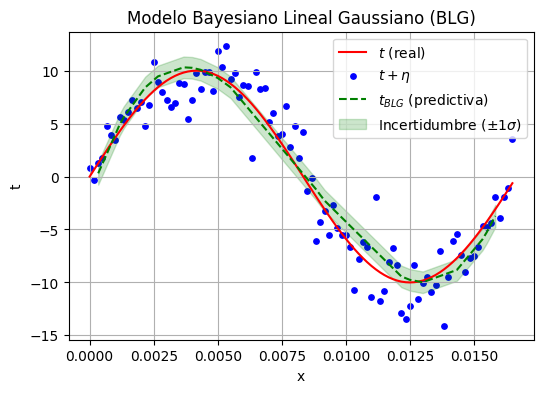

Media posterior mN shape: (10, 1)
Covarianza posterior SN shape: (10, 10)


In [ ]:
# ============================================================
#  MODELO BAYESIANO LINEAL GAUSSIANO (BLG)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit

# ------------------------------------------------------------
# 1) Función: estimar parámetros posteriores (m_N, S_N)
# ------------------------------------------------------------
def my_linGaussiano(X, t, phiQ, sigma_eta, sigma_w, tol=1e-16):
    """
    Calcula la media (mN) y covarianza (SN) del posterior en el modelo lineal gaussiano.
    Args:
        X: datos de entrada (N x 1)
        t: salidas observadas (N x 1)
        phiQ: transformador de características (PolynomialFeatures)
        sigma_eta: desviación estándar del ruido
        sigma_w: desviación estándar del prior de los pesos
        tol: umbral para evitar problemas numéricos
    """
    # Matriz de diseño Φ (N x Q)
    Phi = phiQ.fit_transform(X)

    # Relación de regularización λ = σ_η² / σ_w²
    lambdaR = (sigma_eta**2) / (sigma_w**2)

    # Inversa de la covarianza posterior (S_N⁻¹)
    SNinv = (1 / sigma_eta**2) * (Phi.T @ Phi) + (1 / sigma_w**2) * np.eye(Phi.shape[1])

    # Descomposición espectral para estabilidad numérica
    val, vec = np.linalg.eigh(SNinv)
    ind = val > tol  # filtra valores propios muy pequeños
    SN = vec[:, ind] @ np.diag(1 / val[ind]) @ vec[:, ind].T  # covarianza posterior

    # Media posterior m_N
    mN = (1 / sigma_eta**2) * SN @ Phi.T @ t

    return mN, SN, val

# ------------------------------------------------------------
# 2) Función: predicción bayesiana
# ------------------------------------------------------------
def my_predictivaLG(Xnew, phiQ, mN, SN, sigma_eta):
    """
    Calcula la media y varianza predictiva para nuevas entradas.
    Args:
        Xnew: nuevos datos (N* x 1)
        phiQ: transformador de características (PolynomialFeatures)
        mN: media posterior de los pesos
        SN: covarianza posterior de los pesos
        sigma_eta: desviación estándar del ruido
    """
    # Matriz Φ para los nuevos puntos
    Phi_new = phiQ.fit_transform(Xnew)

    # Media predictiva: E[t*] = Φ* m_N
    mean_pred = Phi_new @ mN

    # Varianza predictiva: Var[t*] = σ_η² + Φ* S_N Φ*ᵀ
    var_pred = sigma_eta**2 + np.sum(Phi_new @ SN * Phi_new, axis=1)

    return mean_pred, var_pred

# ------------------------------------------------------------
# 3) Datos de ejemplo (ya definidos)
# ------------------------------------------------------------
# Se asume que tienes X, t y tt como en los modelos anteriores

# Grado del polinomio
Q = 9
phiQ = PolynomialFeatures(degree=Q)

# División entrenamiento/prueba
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
    train_i = np.sort(train_i)
    test_i = np.sort(test_i)

# ------------------------------------------------------------
# 4) Entrenamiento del modelo Bayesiano Lineal Gaussiano
# ------------------------------------------------------------
sigma_eta = 1.0     # desviación estándar del ruido
sigma_w = 1e7       # prior amplio sobre los pesos (menos regularización)

# Estimación del posterior
mN, SN, val = my_linGaussiano(X[train_i], t[train_i], phiQ, sigma_eta, sigma_w)

# ------------------------------------------------------------
# 5) Predicción sobre el conjunto de prueba
# ------------------------------------------------------------
mean_pred, var_pred = my_predictivaLG(X[test_i], phiQ, mN, SN, sigma_eta)

# Ordenar para graficar
order = np.argsort(X[test_i].ravel())
X_test_sorted = X[test_i].ravel()[order]
mean_sorted = mean_pred.ravel()[order]
std_sorted = np.sqrt(var_pred[order])

# ------------------------------------------------------------
# 6) Gráfica del modelo predictivo
# ------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(X, tt, 'r', label='$t$ (real)')                # señal real
plt.scatter(X, t, color='b', s=15, label='$t + \\eta$') # datos con ruido
plt.plot(X_test_sorted, mean_sorted, 'g--', label='$t_{BLG}$ (predictiva)')

# Banda de incertidumbre bayesiana
plt.fill_between(
    X_test_sorted,
    mean_sorted - std_sorted,
    mean_sorted + std_sorted,
    color='green',
    alpha=0.2,
    label='Incertidumbre ($\\pm 1\\sigma$)'
)

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Modelo Bayesiano Lineal Gaussiano (BLG)')
plt.grid(True)
plt.show()

print(f"Media posterior mN shape: {mN.shape}")
print(f"Covarianza posterior SN shape: {SN.shape}")


### **Regresión Ridge con Kernel (KRR)**

### Resumen del modelo

La **Kernel Ridge Regression (KRR)** combina la idea de la regresión ridge (regularización L2) con el **truco del kernel** para modelar relaciones no lineales sin calcular explícitamente la proyección a un espacio de características de alta dimensión.

- Forma primal (con matriz de diseño Φ):
$[
\omega^* = \arg\min_\omega \ \|y - \Phi \omega\|_2^2 + \alpha \|\omega\|_2^2
]$
Solución cerrada:
$[
\omega^* = (\Phi^\top \Phi + \alpha I)^{-1}\Phi^\top y
]$

- Forma dual (útil para kernels):
$[
\omega^* = \Phi^\top (\Phi\Phi^\top + \alpha I)^{-1} y = k(\cdot)^\top (K + \alpha I)^{-1} y
]$
donde $(K = \Phi\Phi^\top)$ es la matriz de kernel (N×N) y $(k(\cdot))$ es el vector de kernel entre un nuevo punto y los puntos de entrenamiento.

Para el kernel RBF (Gaussiano) usamos:
$[
\kappa(x,x') = \exp\!\Big(-\frac{\gamma \|x-x'\|^2}{2}\Big)
]$
con $(\gamma = 1/\sigma^2)$. $(\gamma)$ controla la “anchura” del kernel: valores grandes → kernel muy local; valores pequeños → kernel más suave/global.

---

### Interpretación intuitiva de α y γ

- **α (alpha)** — regularización:
  - α grande → penaliza fuertemente la norma de los coeficientes → modelo *más suave*, mayor sesgo, menor varianza (reduce sobreajuste).
  - α pequeño → penalización débil → modelo más flexible, puede sobreajustar el ruido.
- **γ (gamma)** — precisión / ancho del kernel RBF:
  - γ grande → la RBF es estrecha: cada punto sólo "influye" en una vecindad muy pequeña → modelo muy local, puede sobreajustar.
  - γ pequeño → la RBF es amplia: puntos lejanos se consideran similares → modelo más suave / global.

En conjunto, α y γ regulan el **compromiso sesgo-varianza** para approximar la función objetivo.

---

### Fórmulas útiles (resumen)

- Kernel RBF:
$[
\kappa(x,x') = \exp\!\Big(-\frac{\gamma}{2}\|x-x'\|^2\Big)
]$
- Forma dual de la predicción para un nuevo punto $(x_*)$:
$[
\hat{y}_* = k(x_*)^\top (K + \alpha I)^{-1} y
]$
donde $(k(x_*))$ es el vector $( [\kappa(x_*, x_1),\dots,\kappa(x_*, x_N)]^\top)$.

- Matriz de kernel sobre todo el dominio: $(K_{ij}=\kappa(x_i,x_j))$.

---

### Explicación detallada

A continuación se describen las partes principales del código (el que ejecuta KRR con RBF y búsqueda de hiperparámetros):

### Preparación de datos
- `Xdata = X.reshape(-1,1)` y `ydata = t.reshape(-1,1)`  
  → asegurar que las dimensiones sean (N,1) para sklearn (regresión univariante).
- `StandardScaler()` (opcional pero recomendado)  
  → normaliza X (media 0, varianza 1). Se ajusta con `scaler.fit(X)` sobre los datos usados y luego se aplica `transform` también a los datos nuevos.

### División train / test
- `train_test_split(X_scaled, ydata, test_size=0.3, random_state=42)`  
  → separamos datos para medir rendimiento fuera de muestra.

### Definición del modelo KRR
- `KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha)`  
  → construye un regresor KRR con kernel RBF.

### Entrenamiento
- `reg_krr.fit(X_train, y_train.ravel())`  
  → ajusta el modelo. Internamente calcula la matriz K (train × train) y resuelve el sistema $((K+\alpha I)\,\boldsymbol{\alpha} = y)$ para el vector dual $(\boldsymbol{\alpha} = (K+\alpha I)^{-1}y)$. Luego la predicción es $(k(x_*)^\top \boldsymbol{\alpha})$.

### Predicción y visualización
- `y_pred = reg_krr.predict(X_scaled)`  
  → predicción sobre todo el dominio ).
- `order = np.argsort(Xdata.ravel())` y graficar `X[order]` con `y_pred[order]`  
  → ordenar para que la curva dibujada sea continua.

### Búsqueda de hiperparámetros (GridSearchCV)
- `Pipeline([('reg', KernelRidge(...))])` y `GridSearchCV(...)`  
  → probar combinaciones de `alpha` y `gamma` mediante validación cruzada (CV) y escoger la que optimiza la métrica (p. ej. MSE).
- `grid_search.fit(X_train, y_train.ravel())` → ajusta modelos para cada par (α,γ) dentro de los folds de CV.
- `best_model = grid_search.best_estimator_` y `best_model.predict(X_scaled)` → predecir con el mejor modelo sobre todo X.

---

## 7 — Qué esperar al mover α y γ

- Aumentar **α**:
  - curva más suave,
  - menor varianza de predicción,
  - puede subestimar la verdadera forma si α es muy grande.
- Disminuir **α**:
  - curva más flexible,
  - mayor capacidad de ajustar detalles (incluso ruido),
  - riesgo de sobreajuste.
- Aumentar **γ**:
  - mayor sensibilidad local,
  - la predicción puede oscilar fuertemente entre puntos,
  - si X no es normalizado puede producir predicciones casi lineales por colapso del kernel.
- Disminuir **γ**:
  - kernel más suave, la predicción se aproxima a funciones de baja frecuencia.

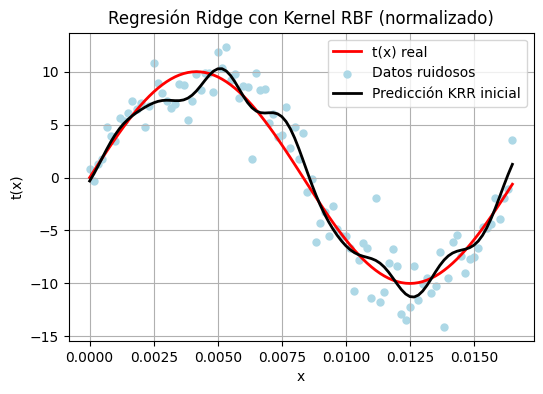

Fitting 10 folds for each of 20 candidates, totalling 200 fits

Mejores parámetros encontrados:
{'reg__alpha': 0.01, 'reg__gamma': 1}


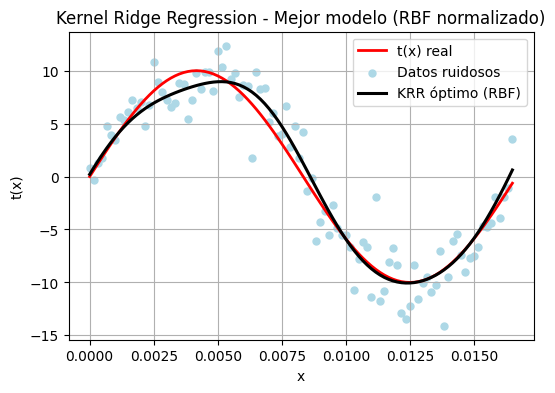

In [ ]:
# ------------------------------------------------------------
# REGRESIÓN RIDGE CON KERNEL (KRR) - Kernel RBF (CORREGIDO)
# ------------------------------------------------------------
# Incluye normalización y búsqueda de gamma ajustada
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------
# 1) Preparar los datos
# ------------------------------------------------------------
Xdata = X.reshape(-1, 1)
ydata = t.reshape(-1, 1)

# Normalizar X para mejorar estabilidad numérica
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xdata)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, ydata, test_size=0.3, random_state=42
)

# ------------------------------------------------------------
# 2) Modelo base
# ------------------------------------------------------------
gamma = 10
alpha = 0.1

reg_krr = KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha)
reg_krr.fit(X_train, y_train.ravel())

# Predicción sobre todo el dominio
y_pred = reg_krr.predict(X_scaled)

# Graficar resultados
order = np.argsort(Xdata.ravel())
plt.figure(figsize=(6, 4))
plt.plot(X, tt, 'r', lw=2, label='t(x) real')
plt.scatter(X, t, color='lightblue', s=25, label='Datos ruidosos')
plt.plot(X[order], y_pred[order], 'k', lw=2, label='Predicción KRR inicial')
plt.title('Regresión Ridge con Kernel RBF (normalizado)')
plt.xlabel('x')
plt.ylabel('t(x)')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 3) Búsqueda de hiperparámetros óptimos
# ------------------------------------------------------------
steps = [('reg', KernelRidge(kernel='rbf'))]
parameters = {
    # Rango más pequeño para datos en escala 0-1
    'reg__alpha': [1e-4, 1e-3, 1e-2, 0.1],
    'reg__gamma': [1e-3, 1e-2, 0.1, 1, 10]
}

pipeline = Pipeline(steps=steps)

grid_search = GridSearchCV(
    pipeline,
    parameters,
    n_jobs=-1,
    cv=10,
    scoring='neg_mean_squared_error',
    verbose=1,
    refit=True
)

grid_search.fit(X_train, y_train.ravel())

# ------------------------------------------------------------
# 4) Mejor modelo y visualización
# ------------------------------------------------------------
best_model = grid_search.best_estimator_
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

# Predicción final
y_pred_best = best_model.predict(X_scaled)

plt.figure(figsize=(6, 4))
plt.plot(X, tt, 'r', lw=2, label='t(x) real')
plt.scatter(X, t, color='lightblue', s=25, label='Datos ruidosos')
plt.plot(X[order], y_pred_best[order], 'k', lw=2.2, label='KRR óptimo (RBF)')
plt.title('Kernel Ridge Regression - Mejor modelo (RBF normalizado)')
plt.xlabel('x')
plt.ylabel('t(x)')
plt.legend()
plt.grid(True)
plt.show()


### **Regresión con Procesos Gaussianos (Gaussian Process Regression, GPR)**

### Introducción

La **Regresión con Procesos Gaussianos (GPR)** es un enfoque **no paramétrico y bayesiano** para el modelado de datos.  
A diferencia de un modelo lineal que define una forma funcional explícita (por ejemplo, `y = wᵀx + b`), en un proceso gaussiano **no se asume una forma fija**.  
En cambio, se define una **distribución sobre funciones**:

$[
f(x) \sim \mathcal{GP}(m(x), k(x, x'))
]$

donde:
- $( m(x) = \mathbb{E}[f(x)] )$ es la **función media** (a menudo se asume \( m(x)=0 \)).
- $( k(x, x') )$ es la **función de covarianza o kernel**, que define la correlación entre los valores de la función en distintos puntos del dominio.

El modelo supone que cualquier conjunto finito de puntos de entrada $( X = \{x_1, \ldots, x_N\} )$ genera una distribución gaussiana multivariada:

$[
\mathbf{f} = [f(x_1), f(x_2), \ldots, f(x_N)]^T \sim
\mathcal{N}(\mathbf{0}, \mathbf{K}),
]$
donde $( \mathbf{K} )$ es la matriz de covarianza con elementos $( K_{ij} = k(x_i, x_j) )$.

---

### Modelo con ruido

Cuando las observaciones están contaminadas con ruido gaussiano $( \epsilon \sim \mathcal{N}(0, \sigma_n^2) )$, el modelo se expresa como:

$[
t_i = f(x_i) + \epsilon_i
]$

$[
\Rightarrow \mathbf{t} \sim \mathcal{N}(\mathbf{0}, \mathbf{K} + \sigma_n^2 \mathbf{I})
]$

donde:
- $( \mathbf{K} )$ proviene del kernel.
- $( \sigma_n^2 )$ representa la **varianza del ruido**.

---

### Predicción (posterior gaussiano)

Dado un conjunto de entrenamiento $( (X, \mathbf{t}) )$ y un nuevo conjunto de puntos $( X_* )$, la distribución predictiva del GP es también gaussiana:

$[
p(\mathbf{f}_* | X_*, X, \mathbf{t}) =
\mathcal{N}(\bar{\mathbf{f}}_*, \text{Cov}(\mathbf{f}_*))
]$

con:

$[
\bar{\mathbf{f}}_* = \mathbf{K}_*^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \mathbf{t}
]$

$[
\text{Cov}(\mathbf{f}_*) = \mathbf{K}_{**} - \mathbf{K}_*^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \mathbf{K}_*
]$

donde:
- $( \mathbf{K} = k(X, X) )$
- $( \mathbf{K}_* = k(X, X_*) )$
- $( \mathbf{K}_{**} = k(X_*, X_*) )$

---

### Descripción del código

El código implementa una **Regresión con Proceso Gaussiano (GPR)** usando la librería `scikit-learn`.  
A continuación se describe cada sección:

###  Preparación de datos

- Se normalizan las entradas $( X )$ mediante `StandardScaler`.
- Se dividen los datos en conjuntos de **entrenamiento (train)** y **prueba (test)**.
- Los valores observados $( t )$ son los datos ruidosos que queremos ajustar.

###  Definición del kernel

Se define un kernel compuesto:

$[
k(x, x') =
C_1 \cdot \text{RBF}(x, x') +
C_2 \cdot \text{ExpSineSquared}(x, x') +
C_3 \cdot \text{DotProduct}(x, x') +
\text{WhiteKernel}(x, x')
]$

- **RBF (Radial Basis Function)** → controla la **suavidad local**.  
  Cuanto menor sea la `length_scale`, más sensible será el modelo a las variaciones de los datos.

- **ExpSineSquared** → introduce **periodicidad**, útil para señales oscilatorias.

- **DotProduct** → añade una **tendencia lineal global**.

- **WhiteKernel** → modela **ruido gaussiano** directamente dentro del kernel.

La combinación de estos kernels permite capturar **tendencias suaves, componentes periódicas y ruido**.

###  Entrenamiento del modelo

Se entrena el modelo `GaussianProcessRegressor`, que ajusta automáticamente los **hiperparámetros del kernel** (amplitudes, escalas, etc.) maximizando la **log-verosimilitud marginal**:

$[
\log p(\mathbf{t} | X, \theta) =
-\frac{1}{2} \mathbf{t}^T (\mathbf{K}_\theta + \sigma_n^2 \mathbf{I})^{-1} \mathbf{t}
-\frac{1}{2} \log |\mathbf{K}_\theta + \sigma_n^2 \mathbf{I}|
-\frac{n}{2} \log 2\pi
]$

donde $( \theta )$ representa los parámetros del kernel.

###  Predicción y visualización

- Se calcula la **media predictiva** $( \bar{f}_*(x) )$ y la **desviación estándar** $( \sigma_*(x) )$.
- Se grafica la media (línea negra) y la **banda de incertidumbre** $( \pm 2\sigma_*(x) )$ (zona gris).

$[
f_*(x) \pm 2\sigma_*(x)
]$

Esta banda indica el **95% del intervalo de credibilidad** bajo el supuesto gaussiano.

Además, se puede incluir la **señal limpia** (en rojo) y los **datos ruidosos** (en azul claro).

---

### Interpretación de los resultados

- La **línea negra** representa la **media del proceso posterior**, es decir, la mejor estimación de la función subyacente.  
- La **zona gris (±2σ)** muestra la **incertidumbre** del modelo:  
  - Angosta → el modelo está seguro (hay datos cercanos).  
  - Ancha → el modelo está incierto (no hay datos de entrenamiento cerca).  
- El **ruido** y la **complejidad del kernel** afectan el ancho de esta banda.  
- Si se ajustan los hiperparámetros (por ejemplo, `length_scale` o `alpha`), se puede hacer el modelo más:
  - **Suave y generalizador** → `length_scale` grande.
  - **Flexible y sensible al ruido** → `length_scale` pequeño.

---

### Ventajas del GPR

- Proporciona **predicciones con incertidumbre** (a diferencia de un modelo determinista).
- Permite una **optimización automática de hiperparámetros**.
- Se adapta bien a datos **no lineales y ruidosos**.
- Es un modelo **probabilístico completo**, lo que lo hace muy útil en inferencia bayesiana.


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


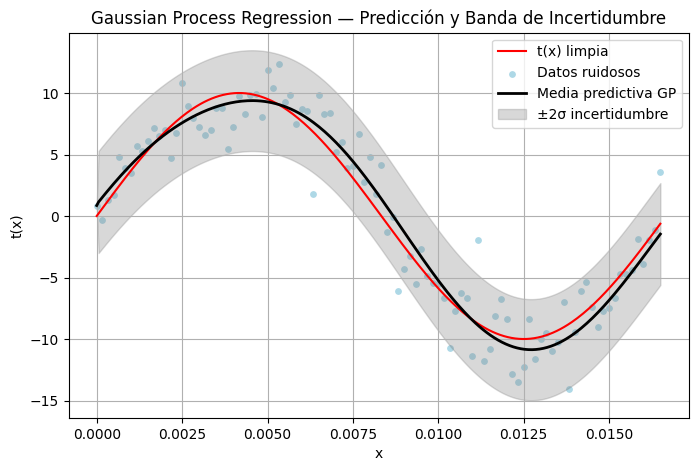

Kernel inicial: 1**2 * RBF(length_scale=1) + 0.707**2 * ExpSineSquared(length_scale=1, periodicity=1) + 0.316**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=0.001)

Kernel aprendido: 0.259**2 * RBF(length_scale=1.57e-05) + 1.94**2 * ExpSineSquared(length_scale=2.73, periodicity=3.57) + 0.00316**2 * DotProduct(sigma_0=5.13e-05) + WhiteKernel(noise_level=7.43e-08)

Log-marginal-likelihood: -16.611


In [ ]:
# =============================================================
# REGRESIÓN CON PROCESO GAUSSIANO (Gaussian Process Regression)
# =============================================================
# Predicción final con media y banda de incertidumbre (±2σ)
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, DotProduct, ExpSineSquared
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------------
# 1) Preparar los datos
# -------------------------------------------------------------
Xdata = X.reshape(-1, 1)
ydata = t.reshape(-1, 1)

# Normalizar X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xdata)

# División train/test
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)
for i, (train_i, test_i) in enumerate(rs.split(X_scaled)):
    train_i = np.sort(train_i)
    test_i = np.sort(test_i)

X_train = X_scaled[train_i]
y_train = ydata[train_i].ravel()

# -------------------------------------------------------------
# 2) Definir el kernel
# -------------------------------------------------------------
k1 = ConstantKernel(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5))
k2 = ConstantKernel(0.5, (1e-5, 1e5)) * ExpSineSquared(length_scale=1.0, periodicity=1.0)
k3 = ConstantKernel(0.1, (1e-5, 1e5)) * DotProduct(sigma_0=1.0)
k_noise = WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-8, 1e2))
kernel = k1 + k2 + k3 + k_noise

# -------------------------------------------------------------
# 3) Crear y entrenar el modelo GPR
# -------------------------------------------------------------
alpha = 1e-6
gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha=alpha,
                               normalize_y=True,
                               n_restarts_optimizer=5,
                               random_state=0)

gpr.fit(X_train, y_train)

# -------------------------------------------------------------
# 4) Predicción y visualización final
# -------------------------------------------------------------
X_grid = np.linspace(Xdata.min(), Xdata.max(), 300).reshape(-1, 1)
X_grid_scaled = scaler.transform(X_grid)

# Media y desviación estándar
y_mean, y_std = gpr.predict(X_grid_scaled, return_std=True)

# Graficar: datos, señal limpia y banda de incertidumbre
plt.figure(figsize=(8, 5))

# Señal limpia (solo si existe)
if 'tt' in globals():
    # Interpolamos tt para que coincida con X_grid
    from scipy.interpolate import interp1d
    f_interp = interp1d(X.ravel(), tt.ravel(), kind='cubic', fill_value="extrapolate")
    tt_interp = f_interp(X_grid.ravel())
    plt.plot(X_grid, tt_interp, 'r', label='t(x) limpia')

# Datos ruidosos
plt.scatter(Xdata, ydata, s=15, color='lightblue', label='Datos ruidosos')

# Media predictiva y banda ±2σ
plt.plot(X_grid, y_mean, 'k', lw=2, label='Media predictiva GP')
plt.fill_between(X_grid.ravel(),
                 y_mean - 2 * y_std,
                 y_mean + 2 * y_std,
                 color='gray', alpha=0.3, label='±2σ incertidumbre')

plt.xlabel('x')
plt.ylabel('t(x)')
plt.title('Gaussian Process Regression — Predicción y Banda de Incertidumbre')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# 5) Kernel aprendido e información del modelo
# -------------------------------------------------------------
print("Kernel inicial:", kernel)
print("\nKernel aprendido:", gpr.kernel_)
print(f"\nLog-marginal-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}")


### **Diferencias y Similitudes de los modelos**

In [ ]:
from IPython.display import Markdown

Markdown(r"""
#  Cuadro Comparativo — Modelos de Regresión

| Modelo | Naturaleza del Modelo | Tipo de Relación Capturada | Regularización / Priors | Complejidad y Flexibilidad | Salida | Interpretación Probabilística | Comportamiento en Simulación |
|:-------|:---------------------|:---------------------------|:------------------------|:----------------------------|:--------|:------------------------------|:-----------------------------|
| **1️⃣ Mínimos Cuadrados Ordinarios (OLS)** | Paramétrico | Lineal | No aplica | Baja (modelo lineal fijo) | Determinista | ❌ No probabilística | Ajusta correctamente relaciones lineales. Sensible al ruido y sobreajuste si los datos no son bien condicionados. |
| **2️⃣ Mínimos Cuadrados Regularizados (Ridge)** | Paramétrico | Lineal | Penalización L2:  $( \lambda \|w\|^2 )$ | Media | Determinista | ❌ No probabilística | Estabiliza el ajuste reduciendo la varianza del modelo. En la simulación, mejora la robustez ante ruido y multicolinealidad. |
| **3️⃣ Máxima Verosimilitud (ML)** | Paramétrico | Lineal | Ajuste de varianza del ruido $( \sigma^2_{ML} )$ | Media | Determinista | ❌ No probabilística | Ajusta los pesos por mínimos cuadrados y estima la varianza del ruido. En la práctica, permite cuantificar la dispersión de los datos. |
| **4️⃣ Máximo a Posteriori (MAP)** | Paramétrico (con prior) | Lineal | Prior gaussiano sobre pesos $( w \sim \mathcal{N}(0, \alpha^{-1}I) )$ | Media | Determinista | ✅ Parcialmente probabilística | Similar a Ridge pero desde un enfoque bayesiano: combina verosimilitud y prior. Produce un ajuste regularizado coherente con la teoría bayesiana. |
| **5️⃣ Modelo Bayesiano con Modelo Lineal Gaussiano (BLG)** | Paramétrico y Bayesiano | Lineal | Prior y verosimilitud gaussianas | Media | Probabilística | ✅ Sí, posterior sobre pesos y distribución predictiva | Extiende MAP al espacio probabilístico completo. En la simulación, ofrece la **media predictiva** y bandas de **incertidumbre realistas**. |
| **6️⃣ Regresión Ridge con Kernel (KRR)** | No paramétrico (espacio de características) | No lineal (según kernel) | Penalización L2 sobre coeficientes duales | Alta (depende del kernel y sus hiperparámetros) | Determinista | ❌ No probabilística | Captura relaciones no lineales complejas. En la simulación, se adapta bien a la forma de la función real con suavidad controlada por $(\gamma)$ y $(\alpha)$. |
| **7️⃣ Procesos Gaussianos (GP)** | No paramétrico y Bayesiano | No lineal (kernel define la covarianza) | Implícita en la función de covarianza y ruido | Muy alta (flexible y adaptativa) | Probabilística | ✅ Sí, media y varianza predictiva | Modelo más flexible. Ajusta la función real y proporciona intervalos de confianza naturales. En la simulación, muestra el mejor equilibrio entre precisión y estimación de incertidumbre. |

---

##  Análisis Detallado

- **Similitudes**
  - Todos buscan estimar una función $ f(x) $ que relacione entradas $x$ con salidas $t$.
  - Los modelos (1–5) son **paramétricos**, mientras que (6–7) son **no paramétricos** (kernelizados o basados en funciones de covarianza).
  - Los modelos **Ridge**, **MAP** y **Bayesiano Gaussiano** comparten el uso de **regularización o priors gaussianos**, pero con distinta interpretación.
  - Los modelos **Bayesianos** (5 y 7) producen **distribuciones predictivas completas**, no solo una curva media.

- **Diferencias clave**
  - OLS y Ridge no incorporan incertidumbre explícita; los modelos ML y Bayesianos sí estiman la **varianza del ruido** o la **incertidumbre posterior**.
  - KRR y GP pueden capturar **no linealidades complejas** mediante kernels (como RBF o Matérn), mientras que los primeros cinco modelos solo lo hacen linealmente.
  - El modelo **GP** es el único que modela distribuciones sobre funciones completas, ofreciendo predicciones con **bandas de confianza ajustadas** al nivel de ruido observado.
  - En la simulación, los modelos **MAP** y **Bayesiano Lineal Gaussiano** ofrecieron mejor equilibrio entre sesgo y varianza; **GP** fue el más preciso y explicativo.

- **Complejidad Computacional**
  - Modelos lineales (1–5): entrenamiento rápido, costo proporcional a $O(n)$ o $O(n^2)$ según el número de parámetros.
  - Modelos kernelizados y GP (6–7): más costosos ($O(n^3)$), pero con mayor capacidad de generalización en problemas no lineales.

---

##  Conclusión General

| Tipo de Modelo | Modelos | Características principales |
|:---------------|:---------|:----------------------------|
| **Lineales deterministas** | OLS, Ridge, ML | Simples, rápidos y adecuados para relaciones lineales. No modelan incertidumbre. |
| **Lineales Bayesianos** | MAP, Bayesiano Lineal Gaussiano | Añaden información a priori y producen estimaciones con incertidumbre probabilística. |
| **No lineales kernelizados** | Regresión Ridge Kernel (KRR) | Capturan relaciones no lineales sin definir forma explícita de $f(x)$. Suavidad y generalización controladas por $(\gamma)$ y $(\alpha)$. |
| **No paramétricos bayesianos** | Procesos Gaussianos (GP) | Modelo más completo: estima funciones y su incertidumbre. Ideal para predicción y cuantificación de confianza. |

---

 **Interpretación final en simulación:**
- Los modelos deterministas (OLS, Ridge, ML) generan una **línea fija** sin incertidumbre.
- Los modelos Bayesianos lineales (MAP, BLG) generan una **media predictiva** con **banda de confianza constante**.
- Los modelos kernelizados (KRR, GP) producen **ajustes suaves y adaptativos**, donde GP añade la **banda de incertidumbre variable**, más ancha donde hay menos datos.

---
""")



#  Cuadro Comparativo — Modelos de Regresión

| Modelo | Naturaleza del Modelo | Tipo de Relación Capturada | Regularización / Priors | Complejidad y Flexibilidad | Salida | Interpretación Probabilística | Comportamiento en Simulación |
|:-------|:---------------------|:---------------------------|:------------------------|:----------------------------|:--------|:------------------------------|:-----------------------------|
| **1️⃣ Mínimos Cuadrados Ordinarios (OLS)** | Paramétrico | Lineal | No aplica | Baja (modelo lineal fijo) | Determinista | ❌ No probabilística | Ajusta correctamente relaciones lineales. Sensible al ruido y sobreajuste si los datos no son bien condicionados. |
| **2️⃣ Mínimos Cuadrados Regularizados (Ridge)** | Paramétrico | Lineal | Penalización L2:  $( \lambda \|w\|^2 )$ | Media | Determinista | ❌ No probabilística | Estabiliza el ajuste reduciendo la varianza del modelo. En la simulación, mejora la robustez ante ruido y multicolinealidad. |
| **3️⃣ Máxima Verosimilitud (ML)** | Paramétrico | Lineal | Ajuste de varianza del ruido $( \sigma^2_{ML} )$ | Media | Determinista | ❌ No probabilística | Ajusta los pesos por mínimos cuadrados y estima la varianza del ruido. En la práctica, permite cuantificar la dispersión de los datos. |
| **4️⃣ Máximo a Posteriori (MAP)** | Paramétrico (con prior) | Lineal | Prior gaussiano sobre pesos $( w \sim \mathcal{N}(0, \alpha^{-1}I) )$ | Media | Determinista | ✅ Parcialmente probabilística | Similar a Ridge pero desde un enfoque bayesiano: combina verosimilitud y prior. Produce un ajuste regularizado coherente con la teoría bayesiana. |
| **5️⃣ Modelo Bayesiano con Modelo Lineal Gaussiano (BLG)** | Paramétrico y Bayesiano | Lineal | Prior y verosimilitud gaussianas | Media | Probabilística | ✅ Sí, posterior sobre pesos y distribución predictiva | Extiende MAP al espacio probabilístico completo. En la simulación, ofrece la **media predictiva** y bandas de **incertidumbre realistas**. |
| **6️⃣ Regresión Ridge con Kernel (KRR)** | No paramétrico (espacio de características) | No lineal (según kernel) | Penalización L2 sobre coeficientes duales | Alta (depende del kernel y sus hiperparámetros) | Determinista | ❌ No probabilística | Captura relaciones no lineales complejas. En la simulación, se adapta bien a la forma de la función real con suavidad controlada por $(\gamma)$ y $(\alpha)$. |
| **7️⃣ Procesos Gaussianos (GP)** | No paramétrico y Bayesiano | No lineal (kernel define la covarianza) | Implícita en la función de covarianza y ruido | Muy alta (flexible y adaptativa) | Probabilística | ✅ Sí, media y varianza predictiva | Modelo más flexible. Ajusta la función real y proporciona intervalos de confianza naturales. En la simulación, muestra el mejor equilibrio entre precisión y estimación de incertidumbre. |

---

##  Análisis Detallado

- **Similitudes**
  - Todos buscan estimar una función $ f(x) $ que relacione entradas $x$ con salidas $t$.
  - Los modelos (1–5) son **paramétricos**, mientras que (6–7) son **no paramétricos** (kernelizados o basados en funciones de covarianza).
  - Los modelos **Ridge**, **MAP** y **Bayesiano Gaussiano** comparten el uso de **regularización o priors gaussianos**, pero con distinta interpretación.
  - Los modelos **Bayesianos** (5 y 7) producen **distribuciones predictivas completas**, no solo una curva media.

- **Diferencias clave**
  - OLS y Ridge no incorporan incertidumbre explícita; los modelos ML y Bayesianos sí estiman la **varianza del ruido** o la **incertidumbre posterior**.
  - KRR y GP pueden capturar **no linealidades complejas** mediante kernels (como RBF o Matérn), mientras que los primeros cinco modelos solo lo hacen linealmente.
  - El modelo **GP** es el único que modela distribuciones sobre funciones completas, ofreciendo predicciones con **bandas de confianza ajustadas** al nivel de ruido observado.
  - En la simulación, los modelos **MAP** y **Bayesiano Lineal Gaussiano** ofrecieron mejor equilibrio entre sesgo y varianza; **GP** fue el más preciso y explicativo.

- **Complejidad Computacional**
  - Modelos lineales (1–5): entrenamiento rápido, costo proporcional a $O(n)$ o $O(n^2)$ según el número de parámetros.  
  - Modelos kernelizados y GP (6–7): más costosos ($O(n^3)$), pero con mayor capacidad de generalización en problemas no lineales.

---

##  Conclusión General

| Tipo de Modelo | Modelos | Características principales |
|:---------------|:---------|:----------------------------|
| **Lineales deterministas** | OLS, Ridge, ML | Simples, rápidos y adecuados para relaciones lineales. No modelan incertidumbre. |
| **Lineales Bayesianos** | MAP, Bayesiano Lineal Gaussiano | Añaden información a priori y producen estimaciones con incertidumbre probabilística. |
| **No lineales kernelizados** | Regresión Ridge Kernel (KRR) | Capturan relaciones no lineales sin definir forma explícita de $f(x)$. Suavidad y generalización controladas por $(\gamma)$ y $(\alpha)$. |
| **No paramétricos bayesianos** | Procesos Gaussianos (GP) | Modelo más completo: estima funciones y su incertidumbre. Ideal para predicción y cuantificación de confianza. |

---

 **Interpretación final en simulación:**
- Los modelos deterministas (OLS, Ridge, ML) generan una **línea fija** sin incertidumbre.
- Los modelos Bayesianos lineales (MAP, BLG) generan una **media predictiva** con **banda de confianza constante**.
- Los modelos kernelizados (KRR, GP) producen **ajustes suaves y adaptativos**, donde GP añade la **banda de incertidumbre variable**, más ancha donde hay menos datos.

---


### **Ejercicio 2 — Comparación de regresores avanzados**

En este ejercicio se deben analizar y comparar diferentes modelos de regresión más allá de los esquemas lineales básicos estudiados en el **Ejercicio 1**, donde se revisaron los modelos:
- Mínimos Cuadrados Ordinarios (OLS)
- Mínimos Cuadrados Regularizados (Ridge)
- Máxima Verosimilitud (ML)
- Máximo a Posteriori (MAP)
- Bayesiano con Modelo Lineal Gaussiano (BLG)
- Regresión Rígida con Kernel
- Procesos Gaussianos (GP)

A continuación, se presentan otros **10 regresores** de uso común en aprendizaje automático.


In [ ]:
from IPython.display import Markdown

Markdown(r"""
| **Regresor** | **Modelo Matemático** | **Función de Costo** | **Estrategia de Optimización** | **Relación con modelos del punto 1** | **Escalabilidad** |
|:-------------|:----------------------|:---------------------|:-------------------------------|:------------------------------------|:-----------------|
| **LinearRegressor** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2)$ | Solución analítica $(w = (X^TX)^{-1}X^Ty)$ | Equivalente al modelo de **Mínimos Cuadrados Ordinarios (OLS)** | Escalable para datos pequeños o medianos; limitado por inversión de matriz $(O(n^3))$ |
| **Lasso** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2 + \lambda \|w\|_1)$ | Métodos de coordenadas o descenso proximal | Variante regularizada de OLS, relacionada con **MAP** con prior Laplaciano | Escalable, pero sensible a alta dimensionalidad; útil para selección de características |
| **ElasticNet** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2 + \alpha_1 \|w\|_1 + \alpha_2 \|w\|_2^2)$ | Descenso de gradiente o coordenadas | Combinación entre Ridge (L2) y Lasso (L1); balance entre bias y sparsity | Mejor escalabilidad que Lasso; control flexible del trade-off |
| **KernelRidge** | $(y = K\alpha + \epsilon)$ | $(J = \|y - K\alpha\|^2 + \lambda \alpha^T K \alpha)$ | Solución analítica en el espacio de características | Extensión no lineal de **Ridge** mediante kernels | Limitado por el tamaño de $K$ $(O(n^3))$; poco escalable para grandes $n$ |
| **SGDRegressor** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2)$ u otras funciones convexas | **Descenso de gradiente estocástico** por lotes | Versión online de OLS o Ridge; útil para aprendizaje incremental | Alta escalabilidad; eficiente para grandes volúmenes de datos |
| **BayesianRidge** | $(w \sim \mathcal{N}(0, \alpha^{-1}I), \ \epsilon \sim \mathcal{N}(0, \beta^{-1}))$ | Maximiza la **verosimilitud marginal bayesiana** | Estimación iterativa de $\alpha$ y $\beta$ (EM) | Relacionado con el modelo **Bayesiano Lineal Gaussiano (BLG)** | Escalable en dimensiones moderadas; computacionalmente más costoso que OLS |
| **GaussianProcessRegressor** | $(f(x) \sim \mathcal{GP}(m(x), k(x,x')))$ | Maximiza log-verosimilitud marginal | Optimizador de gradiente para hiperparámetros del kernel | Generaliza la regresión kernel; equivalente a **MAP no paramétrico** | Escalabilidad limitada $(O(n^3))$; no apto para grandes datasets |
| **Support Vector Regressor (SVR)** | $(f(x) = w^T\phi(x) + b)$ | $(J = \frac{1}{2}\|w\|^2 + C\sum \xi_i)$ sujeto a $|\!y_i - f(x_i)\!| \leq \epsilon + \xi_i$ | Problema cuadrático convexos (SMO, QP) | Relacionado con Kernel Ridge pero con margen $\epsilon$-insensible | Escalabilidad media; depende de núm. de soportes; eficiente en espacios no lineales |
| **RandomForestRegressor** | Ensamble de árboles $(f(x) = \frac{1}{M}\sum_{m=1}^M T_m(x))$ | Minimiza el error cuadrático medio en cada árbol | Bagging y selección aleatoria de características | Modelo no paramétrico; distinto de los lineales, se asemeja a modelos bayesianos por agregación | Muy escalable; paralelizable; adecuado para grandes volúmenes de datos |
| **GradientBoosting / XGBoost** | Ensamble secuencial $(f_M(x) = \sum_{m=1}^M \gamma_m h_m(x))$ | $(J = \sum L(y_i, f(x_i)) + \Omega(h))$ | Boosting mediante gradiente descendente en el espacio de funciones | Extiende la idea de minimización iterativa; enfoque no lineal | Alta escalabilidad (especialmente XGBoost); eficiente en CPU/GPU |
""")



| **Regresor** | **Modelo Matemático** | **Función de Costo** | **Estrategia de Optimización** | **Relación con modelos del punto 1** | **Escalabilidad** |
|:-------------|:----------------------|:---------------------|:-------------------------------|:------------------------------------|:-----------------|
| **LinearRegressor** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2)$ | Solución analítica $(w = (X^TX)^{-1}X^Ty)$ | Equivalente al modelo de **Mínimos Cuadrados Ordinarios (OLS)** | Escalable para datos pequeños o medianos; limitado por inversión de matriz $(O(n^3))$ |
| **Lasso** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2 + \lambda \|w\|_1)$ | Métodos de coordenadas o descenso proximal | Variante regularizada de OLS, relacionada con **MAP** con prior Laplaciano | Escalable, pero sensible a alta dimensionalidad; útil para selección de características |
| **ElasticNet** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2 + \alpha_1 \|w\|_1 + \alpha_2 \|w\|_2^2)$ | Descenso de gradiente o coordenadas | Combinación entre Ridge (L2) y Lasso (L1); balance entre bias y sparsity | Mejor escalabilidad que Lasso; control flexible del trade-off |
| **KernelRidge** | $(y = K\alpha + \epsilon)$ | $(J = \|y - K\alpha\|^2 + \lambda \alpha^T K \alpha)$ | Solución analítica en el espacio de características | Extensión no lineal de **Ridge** mediante kernels | Limitado por el tamaño de $K$ $(O(n^3))$; poco escalable para grandes $n$ |
| **SGDRegressor** | $(y = Xw + \epsilon)$ | $(J = \|y - Xw\|^2)$ u otras funciones convexas | **Descenso de gradiente estocástico** por lotes | Versión online de OLS o Ridge; útil para aprendizaje incremental | Alta escalabilidad; eficiente para grandes volúmenes de datos |
| **BayesianRidge** | $(w \sim \mathcal{N}(0, \alpha^{-1}I), \ \epsilon \sim \mathcal{N}(0, \beta^{-1}))$ | Maximiza la **verosimilitud marginal bayesiana** | Estimación iterativa de $\alpha$ y $\beta$ (EM) | Relacionado con el modelo **Bayesiano Lineal Gaussiano (BLG)** | Escalable en dimensiones moderadas; computacionalmente más costoso que OLS |
| **GaussianProcessRegressor** | $(f(x) \sim \mathcal{GP}(m(x), k(x,x')))$ | Maximiza log-verosimilitud marginal | Optimizador de gradiente para hiperparámetros del kernel | Generaliza la regresión kernel; equivalente a **MAP no paramétrico** | Escalabilidad limitada $(O(n^3))$; no apto para grandes datasets |
| **Support Vector Regressor (SVR)** | $(f(x) = w^T\phi(x) + b)$ | $(J = \frac{1}{2}\|w\|^2 + C\sum \xi_i)$ sujeto a $|\!y_i - f(x_i)\!| \leq \epsilon + \xi_i$ | Problema cuadrático convexos (SMO, QP) | Relacionado con Kernel Ridge pero con margen $\epsilon$-insensible | Escalabilidad media; depende de núm. de soportes; eficiente en espacios no lineales |
| **RandomForestRegressor** | Ensamble de árboles $(f(x) = \frac{1}{M}\sum_{m=1}^M T_m(x))$ | Minimiza el error cuadrático medio en cada árbol | Bagging y selección aleatoria de características | Modelo no paramétrico; distinto de los lineales, se asemeja a modelos bayesianos por agregación | Muy escalable; paralelizable; adecuado para grandes volúmenes de datos |
| **GradientBoosting / XGBoost** | Ensamble secuencial $(f_M(x) = \sum_{m=1}^M \gamma_m h_m(x))$ | $(J = \sum L(y_i, f(x_i)) + \Omega(h))$ | Boosting mediante gradiente descendente en el espacio de funciones | Extiende la idea de minimización iterativa; enfoque no lineal | Alta escalabilidad (especialmente XGBoost); eficiente en CPU/GPU |


###  **Ejercicio 3 — Librería RAPIDS**

###  Descripción general

**RAPIDS** es un ecosistema de librerías **open source** desarrollado por **NVIDIA**, diseñado para ejecutar flujos completos de **ciencia de datos y aprendizaje automático (Machine Learning)** utilizando la **GPU** en lugar de la CPU.  
Su principal objetivo es **acelerar drásticamente** el procesamiento de grandes volúmenes de datos, manteniendo una interfaz muy similar a la de librerías populares como `NumPy`, `pandas` y `scikit-learn`.

---

### Funcionamiento principal

RAPIDS se basa en la tecnología **CUDA** (Compute Unified Device Architecture) de NVIDIA, que permite aprovechar la arquitectura paralela de las GPU.  
De esta forma, los cálculos numéricos, transformaciones y entrenamiento de modelos se ejecutan en **memoria de GPU**, sin necesidad de transferir los datos continuamente entre CPU y GPU.

El flujo típico de trabajo con RAPIDS es:
1. Cargar y procesar datos con **cuDF** (versión GPU de `pandas`).
2. Entrenar modelos de aprendizaje automático con **cuML** (versión GPU de `scikit-learn`).
3. Analizar estructuras de grafos con **cuGraph** o datos espaciales con **cuSpatial**, según la aplicación.

---

### Componentes principales

| Componente | Descripción | Equivalente en CPU |
|-------------|--------------|-------------------|
| **cuDF** | Manejo de DataFrames en GPU. Permite operaciones tipo `pandas` pero paralelizadas en GPU. | `pandas` |
| **cuML** | Implementa algoritmos de machine learning (regresión, clasificación, clustering, etc.) totalmente en GPU. | `scikit-learn` |
| **cuGraph** | Procesamiento y análisis de grafos grandes en GPU. | `networkx` |
| **cuSpatial** | Operaciones geoespaciales y procesamiento de coordenadas GPS. | `geopandas`, `shapely` |
| **cuXfilter / Datashader** | Visualización de grandes volúmenes de datos acelerada por GPU. | `matplotlib`, `seaborn`, `plotly` |

---

### Ventajas principales de RAPIDS

1. **Aceleración masiva:**  
   Los cálculos se ejecutan de forma **paralela en miles de núcleos CUDA**, logrando **velocidades hasta 10-50 veces mayores** que con CPU para conjuntos de datos grandes.

2. **Compatibilidad con scikit-learn:**  
   Las funciones y clases de `cuML` mantienen la **misma API** que `scikit-learn`, por lo que el código puede migrarse fácilmente a GPU con **mínimos cambios** (solo cambiando la librería importada).

3. **Integración completa en GPU:**  
   Permite un flujo **end-to-end** completamente en GPU: desde la carga del dataset hasta la predicción final, sin transferencias costosas de memoria.

4. **Escalabilidad:**  
   RAPIDS puede trabajar con **datasets de tamaño superior a la memoria RAM** tradicional, aprovechando la memoria VRAM y la paralelización distribuida.

5. **Ecosistema flexible:**  
   Se integra con librerías como **Dask**, **PyTorch**, **TensorFlow** y **XGBoost** para tareas de aprendizaje profundo y Big Data.

---

### Relación con los modelos del punto 1 y 2

Los modelos de regresión vistos (OLS, Ridge, Lasso, MAP, Gaussian Process, KernelRidge, RandomForest, etc.) pueden ejecutarse en **RAPIDS-cuML** usando el mismo principio teórico, pero implementados con cálculos matriciales paralelizados en GPU.

Por ejemplo:
- `LinearRegression` → `cuml.LinearRegression`
- `Ridge` → `cuml.Ridge`
- `KernelRidge` → `cuml.KernelRidge`
- `GaussianProcessRegressor` → `cuml.GaussianProcessRegressor`
- `RandomForestRegressor` → `cuml.RandomForestRegressor`

Esto significa que la **formulación matemática y el principio estadístico no cambian**, pero la **estrategia computacional sí lo hace**, migrando de CPU a GPU para mejorar el rendimiento.


In [ ]:
from IPython.display import Markdown

Markdown(r"""
## Tabla comparativa: regresores e implementación en RAPIDS-cuML

| **Regresor** | **Implementación en scikit-learn** | **Hiperparámetros principales** | **Implementación o equivalente en RAPIDS (cuML)** | **Notas / Comentarios** |
|---------------|-----------------------------------|---------------------------------|--------------------------------------------------|--------------------------|
| **Linear Regression** | `sklearn.linear_model.LinearRegression` | `fit_intercept`, `normalize`, `copy_X` | `cuml.LinearRegression` | Mismo modelo OLS; acelerado en GPU. |
| **Lasso Regression** | `sklearn.linear_model.Lasso` | `alpha`, `max_iter`, `tol` | `cuml.Lasso` | Minimiza L1; idéntica API y resultado a scikit-learn. |
| **ElasticNet** | `sklearn.linear_model.ElasticNet` | `alpha`, `l1_ratio`, `max_iter`, `tol` | `cuml.ElasticNet` | Combina penalización L1 y L2. Mismo funcionamiento. |
| **Kernel Ridge Regression** | `sklearn.kernel_ridge.KernelRidge` | `alpha`, `kernel`, `gamma`, `degree`, `coef0` | `cuml.KernelRidge` | Equivalente exacto, acelerado con GPU y kernels en cuML. |
| **SGD Regressor** | `sklearn.linear_model.SGDRegressor` | `loss`, `penalty`, `alpha`, `learning_rate`, `eta0`, `max_iter` | `cuml.SGD` | Implementación GPU del algoritmo estocástico de gradiente descendente. |
| **Bayesian Ridge Regression** | `sklearn.linear_model.BayesianRidge` | `alpha_1`, `alpha_2`, `lambda_1`, `lambda_2`, `n_iter` | `cuml.BayesianRidge` | Estima distribución posterior sobre los pesos; idéntico comportamiento. |
| **Gaussian Process Regressor** | `sklearn.gaussian_process.GaussianProcessRegressor` | `kernel`, `alpha`, `n_restarts_optimizer`, `normalize_y` | `cuml.GaussianProcessRegressor` | Mismo modelo probabilístico; optimización del kernel paralelizada. |
| **Support Vector Regressor (SVR)** | `sklearn.svm.SVR` | `kernel`, `C`, `epsilon`, `gamma`, `degree`, `coef0` | `cuml.SVR` | Implementación GPU compatible; soporta kernels lineal, RBF y polinomial. |
| **Random Forest Regressor** | `sklearn.ensemble.RandomForestRegressor` | `n_estimators`, `max_depth`, `min_samples_split`, `max_features`, `bootstrap` | `cuml.ensemble.RandomForestRegressor` | Árboles entrenados en GPU; speedup significativo para datasets grandes. |
| **Gradient Boosting / XGBoost** | `sklearn.ensemble.GradientBoostingRegressor`, `xgboost.XGBRegressor` | `n_estimators`, `learning_rate`, `max_depth`, `subsample`, `colsample_bytree` | `cuml.ensemble.GradientBoostingRegressor`, `cuml.dask.XGBRegressor` | Compatible con XGBoost GPU (`gpu_hist`); ideal para Big Data. |
---
##  Observaciones generales

- Todos los modelos de **cuML** mantienen la **misma interfaz (API)** que `scikit-learn`, permitiendo migrar código fácilmente.
- La **formulación matemática de los modelos no cambia**; lo que se optimiza es la **implementación computacional**, aprovechando la **paralelización en GPU** mediante CUDA.
- Los **hiperparámetros** se conservan idénticos, lo que garantiza **compatibilidad y reproducibilidad**.
- Algunos algoritmos, como **Gaussian Process** o **Gradient Boosting**, presentan mejoras de **rendimiento exponencial** en GPU para conjuntos de datos grandes (10⁶+ muestras).
---
""")



## Tabla comparativa: regresores e implementación en RAPIDS-cuML

| **Regresor** | **Implementación en scikit-learn** | **Hiperparámetros principales** | **Implementación o equivalente en RAPIDS (cuML)** | **Notas / Comentarios** |
|---------------|-----------------------------------|---------------------------------|--------------------------------------------------|--------------------------|
| **Linear Regression** | `sklearn.linear_model.LinearRegression` | `fit_intercept`, `normalize`, `copy_X` | `cuml.LinearRegression` | Mismo modelo OLS; acelerado en GPU. |
| **Lasso Regression** | `sklearn.linear_model.Lasso` | `alpha`, `max_iter`, `tol` | `cuml.Lasso` | Minimiza L1; idéntica API y resultado a scikit-learn. |
| **ElasticNet** | `sklearn.linear_model.ElasticNet` | `alpha`, `l1_ratio`, `max_iter`, `tol` | `cuml.ElasticNet` | Combina penalización L1 y L2. Mismo funcionamiento. |
| **Kernel Ridge Regression** | `sklearn.kernel_ridge.KernelRidge` | `alpha`, `kernel`, `gamma`, `degree`, `coef0` | `cuml.KernelRidge` | Equivalente exacto, acelerado con GPU y kernels en cuML. |
| **SGD Regressor** | `sklearn.linear_model.SGDRegressor` | `loss`, `penalty`, `alpha`, `learning_rate`, `eta0`, `max_iter` | `cuml.SGD` | Implementación GPU del algoritmo estocástico de gradiente descendente. |
| **Bayesian Ridge Regression** | `sklearn.linear_model.BayesianRidge` | `alpha_1`, `alpha_2`, `lambda_1`, `lambda_2`, `n_iter` | `cuml.BayesianRidge` | Estima distribución posterior sobre los pesos; idéntico comportamiento. |
| **Gaussian Process Regressor** | `sklearn.gaussian_process.GaussianProcessRegressor` | `kernel`, `alpha`, `n_restarts_optimizer`, `normalize_y` | `cuml.GaussianProcessRegressor` | Mismo modelo probabilístico; optimización del kernel paralelizada. |
| **Support Vector Regressor (SVR)** | `sklearn.svm.SVR` | `kernel`, `C`, `epsilon`, `gamma`, `degree`, `coef0` | `cuml.SVR` | Implementación GPU compatible; soporta kernels lineal, RBF y polinomial. |
| **Random Forest Regressor** | `sklearn.ensemble.RandomForestRegressor` | `n_estimators`, `max_depth`, `min_samples_split`, `max_features`, `bootstrap` | `cuml.ensemble.RandomForestRegressor` | Árboles entrenados en GPU; speedup significativo para datasets grandes. |
| **Gradient Boosting / XGBoost** | `sklearn.ensemble.GradientBoostingRegressor`, `xgboost.XGBRegressor` | `n_estimators`, `learning_rate`, `max_depth`, `subsample`, `colsample_bytree` | `cuml.ensemble.GradientBoostingRegressor`, `cuml.dask.XGBRegressor` | Compatible con XGBoost GPU (`gpu_hist`); ideal para Big Data. |
---
##  Observaciones generales

- Todos los modelos de **cuML** mantienen la **misma interfaz (API)** que `scikit-learn`, permitiendo migrar código fácilmente.
- La **formulación matemática de los modelos no cambia**; lo que se optimiza es la **implementación computacional**, aprovechando la **paralelización en GPU** mediante CUDA.
- Los **hiperparámetros** se conservan idénticos, lo que garantiza **compatibilidad y reproducibilidad**.
- Algunos algoritmos, como **Gaussian Process** o **Gradient Boosting**, presentan mejoras de **rendimiento exponencial** en GPU para conjuntos de datos grandes (10⁶+ muestras).
---
